#  Demo file: RI confidence intervals

In [1]:
%show_gui

In [2]:
//  Some preliminaries for stata
clear all
set seed 12345
set matsize 11000
set scheme s1mono

//  Add /ado/ subdirectory to top of Stata's search path.
//  Assume we are EITHER in the root of the github repo OR in the /demo/ folder to begin.
if regexm("`c(pwd)'","demo") local pwd = subinstr(subinstr("`c(pwd)'","\","/",.),"/demo", "", 1)
else local pwd "`c(pwd)'"
di as err "The current working directory is `pwd'"
adopath ++`pwd'/ado 

// Force reload of Stata programs
capture program drop ri_estimates








The current working directory is D:/GitHub/RI_CI

  [1]              "D:/GitHub/RI_CI/ado"
  [2]  (BASE)      "C:\Program Files (x86)\Stata15\ado\base/"
  [3]  (SITE)      "C:\Program Files (x86)\Stata15\ado\site/"
  [4]              "."
  [5]  (PERSONAL)  "c:\ado\personal/"
  [6]  (PLUS)      "c:\ado\plus/"
  [7]  (OLDPLACE)  "c:\ado/"
  [8]              "C:\Programs\Anaconda3\Lib\site-packages\stata_kernel\ado"



##  Simulate some data

Let's generate 500 observations according to the genrative model
\begin{align}
y_0 &= e_0 \\
y_1 &= y_0 + \tau
\end{align}

with $\tau = 1$ and $e_0\sim N(0,1)$

In [3]:
set obs 500
global tau = 1
ge y0 = rnormal()
ge y1 = y0 + $tau


number of observations (_N) was 0, now 500





Let treatment assignment be by simple randomization. We need to do two things:

1. create a set of $R$ feasible randomizations, to feed into the RI machine and to feed into the DGP for observed outcomes; and 
2. generate observed outcome $y$ according to the switching regression 
    \begin{equation}
    y = y_0 + t(y_1 - y_0)
    \end{equation}

In [4]:
global R = 200

In [5]:
ge t_0 = (runiform() >= 0.5)
ge y = y0 + t_0*(y1-y0)

In [6]:
ge i = _n // an identifier for observations, used later to merge potential treatments
tempfile T0 
preserve 
keep i t_0
forvalues r=1/$R {
    ge t_`r' = (runiform() >= 0.5 )
}
save `T0'
restore 







file C:\Users\az332\AppData\Local\Temp\ST_3bdc_000001.tmp saved



##  Estimate and get a p-value

In [10]:
ri_estimates, permutations($R) key(i) t1(t , filename(`T0')) pvals(t) : regress y t
mat li r(RESULTS)
global tstat = el(r(RESULTS),rownumb(r(RESULTS),"t"),colnumb(r(RESULTS),"t"))
global pval  = el(r(RESULTS),rownumb(r(RESULTS),"t"),colnumb(r(RESULTS),"p"))
mat T0 = r(T0)
di "The t statistic is $tstat, with p-value $pval"

. des

Contains data
  obs:           500                          
 vars:             5                          
 size:        10,000                          
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
              storage   display    value
variable name   type    format     label      variable label
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
y0              float   %9.0g                 
y1              float   %9.0g                 
t_0             float   %9.0g                 
y               float   %9.0g                 
i               float   %9.0g       




number of observations will be reset to 200
Press any key to continue, or Break to abort
number of observations (_N) was 0, now 200


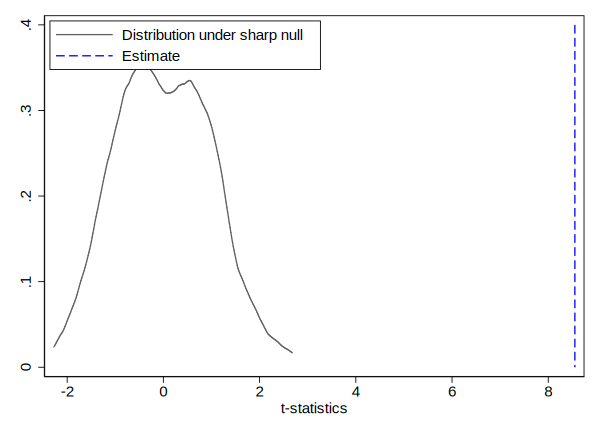

In [12]:
// Visualizing result
preserve
drop _all 
svmat T0, names(tstat)
twoway (kdensity tstat) ///
    (scatteri 0.4 $tstat 0 $tstat, recast(line) lcolor(blue) lpattern(dash)) ///
    , /// xline($tstat, lcolor(blue))  ///
    xtitle("t-statistics") /// xscale(range($tstat)) /// 
    legend(order(1 "Distribution under sharp null" 2 "Estimate") cols(1) position(11) ring(0))
restore

## Calculate CI